In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [111]:
!wget https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/refs/heads/master/ann_logistic_extra/ecommerce_data.csv;

--2025-05-10 12:04:39--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/refs/heads/master/ann_logistic_extra/ecommerce_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12381 (12K) [text/plain]
Saving to: ‘ecommerce_data.csv.9’

ecommerce_data.csv. 100%[===================>]  12.09K  --.-KB/s    in 0.003s  

2025-05-10 12:04:39 (4.54 MB/s) - ‘ecommerce_data.csv.9’ saved [12381/12381]



In [112]:
def get_data():
    df = pd.read_csv('ecommerce_data.csv')
    # df.head()
    # easier to work with numpy array
    data = df.to_numpy()

    # shuffle our data, by the row. The columns don't get mixed
    np.random.shuffle(data)

    # split features and labels
    X = data[:, :-1]
    Y = data[:, -1].astype(np.int32)

    # one-hot encoding for time of day
    N, D = X.shape
    X2 = np.zeros((N, D+3))  # add only three because we can replace one column
    X2[:, :(D-1)] = X[:, :(D-1)]

    for n in range(N):
        t = int(X[n, D-1])  # t is the value in that cell
        X2[n, t+D-1] = 1    # puts a value of 1 in the t-th column of that row
                            # adds 1 in col. 7 for a value 3, adds 1 in col. 6

    # method 2 (more efficient)
    # Z = np.zeros((N, 4))
    # Z[np.arange(N), X[:, D-1].astype(np.int32)] = 1
    # Z[(r1, r2, r3, ...), (c1, c2, c3, ...)] = value
    # X2[:, -4:] = Z

    # assign X2 back to X
    X = X2

    # split train and test
    Xtrain = X[:-100]
    Ytrain = Y[:-100]
    Xtest = X[-100:]
    Ytest = Y[-100:]

    # normalize columns 1 and 2
    for i in (1, 2):
        m = Xtrain[:, i].mean()
        s = Xtrain[:, i].std()
        Xtrain[:, i] = (Xtrain[:, i] - m) / s
        Xtest[:, i] = (Xtest[:, i] - m) / s

    return Xtrain, Ytrain, Xtest, Ytest

In [113]:
def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [114]:
Xtrain, Ytrain, Xtest, Ytest = get_data()

In [115]:
D = Xtrain.shape[1]
K = len(set(Ytrain) | set(Ytest))
M = 5  # number of hidden units

In [116]:
Ytrain_ind = y2indicator(Ytrain, K)
Ytest_ind = y2indicator(Ytest, K)

In [117]:
# randomly initialize weights
W1 = np.random.randn(D, M)  # hidden layer
b1 = np.zeros(M)
W2 = np.random.randn(M, K)  # output layer
b2 = np.zeros(K)

In [118]:
def softmax(a):
    expa = np.exp(a)
    return expa / expa.sum(axis=1, keepdims=True)

def forward(X, W1, b1, W2, b2):
    Z = np.tanh(X.dot(W1) + b1)
    return softmax(Z.dot(W2) + b2), Z

def predict(P_Y_given_X):
    return np.argmax(P_Y_given_X, axis=1)

def classification_rate(Y, P):
    return np.mean(Y == P)

def cross_entropy(Y_ind, pY):
    return -np.mean(Y_ind * np.log(pY))

In [119]:
train_costs = []
test_costs = []
learning_rate = 0.0001
epochs = 10000

for epoch in range(epochs):
    pYtrain, Ztrain = forward(Xtrain, W1, b1, W2, b2)
    pYtest, Ztest = forward(Xtest, W1, b1, W2, b2)

    ctrain = cross_entropy(Ytrain_ind, pYtrain)
    ctest = cross_entropy(Ytest_ind, pYtest)

    train_costs.append(ctrain)
    test_costs.append(ctest)

    # gradient descent
    gW2 = Ztrain.T.dot(pYtrain - Ytrain_ind)
    gb2 = (pYtrain - Ytrain_ind).sum(axis=0)
    dZ = (pYtrain - Ytrain_ind).dot(W2.T) * (1 - Ztrain * Ztrain)  # z' for tahn
    gW1 = Xtrain.T.dot(dZ)
    gb1 = dZ.sum(axis=0)

    W2 -= learning_rate * gW2
    b2 -= learning_rate * gb2
    W1 -= learning_rate * gW1
    b1 -= learning_rate * gb1

    if epoch % 1000 == 0:
        print(f"{epoch}\t{ctrain:.4f}\t{ctest:.4f}")

0	0.8794	0.8603
1000	0.0883	0.1264
2000	0.0700	0.1079
3000	0.0582	0.0909
4000	0.0501	0.0772
5000	0.0449	0.0684
6000	0.0414	0.0647
7000	0.0389	0.0636
8000	0.0371	0.0629
9000	0.0357	0.0621


Final train classification rate: 0.9525
Final test classification rate: 0.92


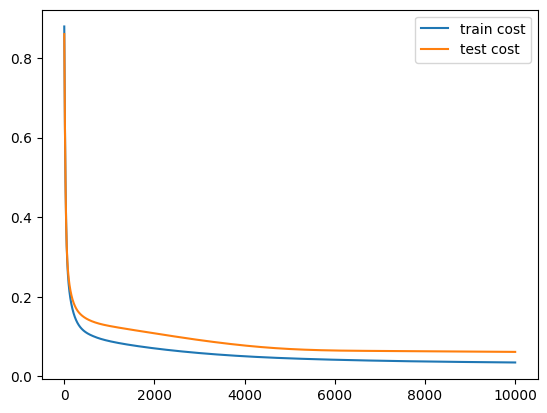

In [120]:
pYtrain, _ = forward(Xtrain, W1, b1, W2, b2)
pYtest, _ = forward(Xtest, W1, b1, W2, b2)

acc_train = classification_rate(Ytrain, predict(pYtrain))
acc_test = classification_rate(Ytest, predict(pYtest))

print("Final train classification rate:", acc_train)
print("Final test classification rate:", acc_test)

plt.plot(train_costs, label='train cost')
plt.plot(test_costs, label='test cost')
plt.legend();